In [186]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
import time


import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [154]:
from sklearn.model_selection import train_test_split


In [196]:
label_data = pd.read_pickle(r'all_metrics_data.pkl')
label_data.head()

X_train, X_test, Y_train, Y_test = train_test_split(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)\
                                                    , label_data.label, test_size=0.2, random_state=22)

In [156]:
from scipy import stats
import pprint

labels_to_correlate = label_data.drop(['label', 'time'], axis=1)

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure[label] = (r,p)

<AxesSubplot:>

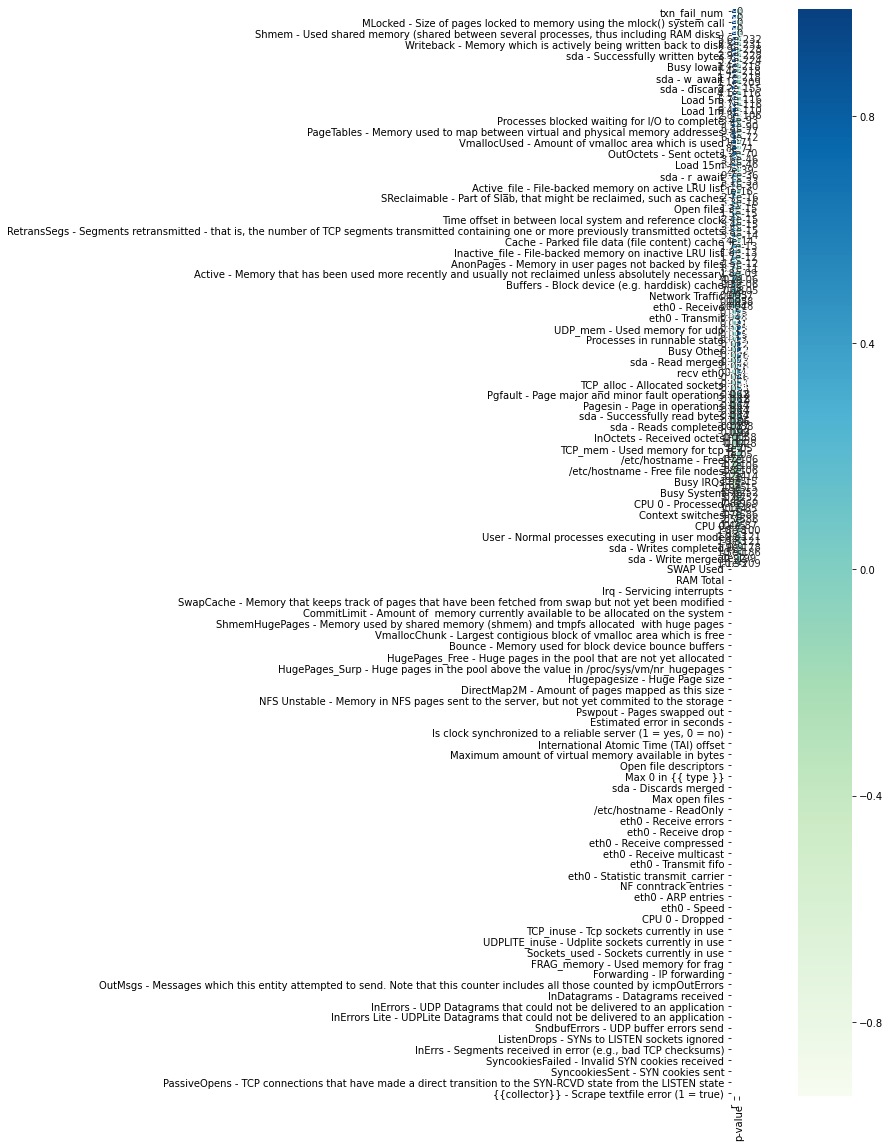

In [157]:
import seaborn as sns

txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

plt.figure(figsize=(20,20))
sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)

                                                      r   p-value
Busy Other                                     0.792394 -0.012070
Nice - Niced processes executing in user mode  0.792394 -0.012070
Processes in runnable state                    0.773381  0.013205
mem_bytes - UDP sockets in that state          0.749241  0.014658
UDP_mem - Used memory for udp                  0.749241  0.014658


<AxesSubplot:>

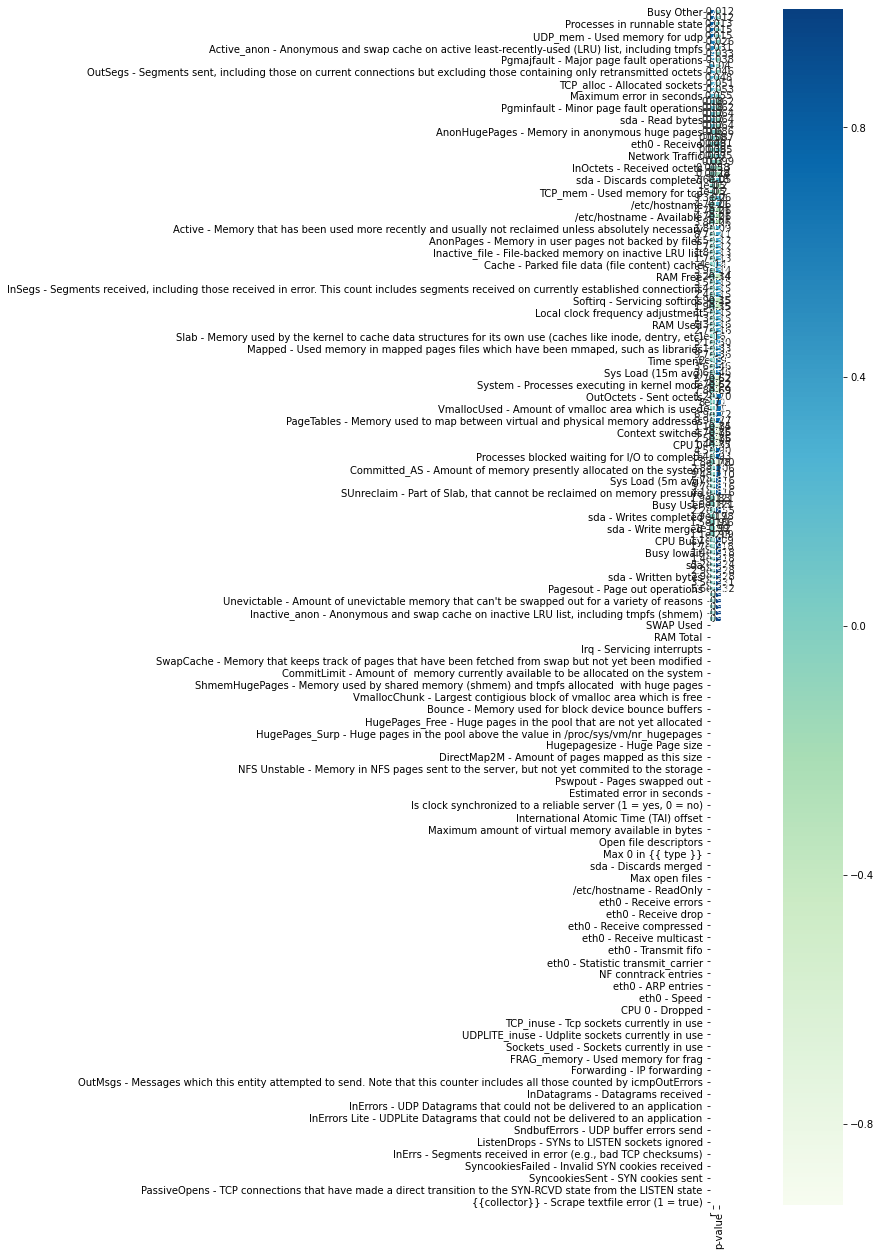

In [158]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pointbiserialr = pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

print(pointbiserialr.head())
plt.figure(figsize=(22,22))
sns.heatmap(pointbiserialr, cmap='GnBu', square=True, annot=True, linewidths=.5)

<AxesSubplot:>

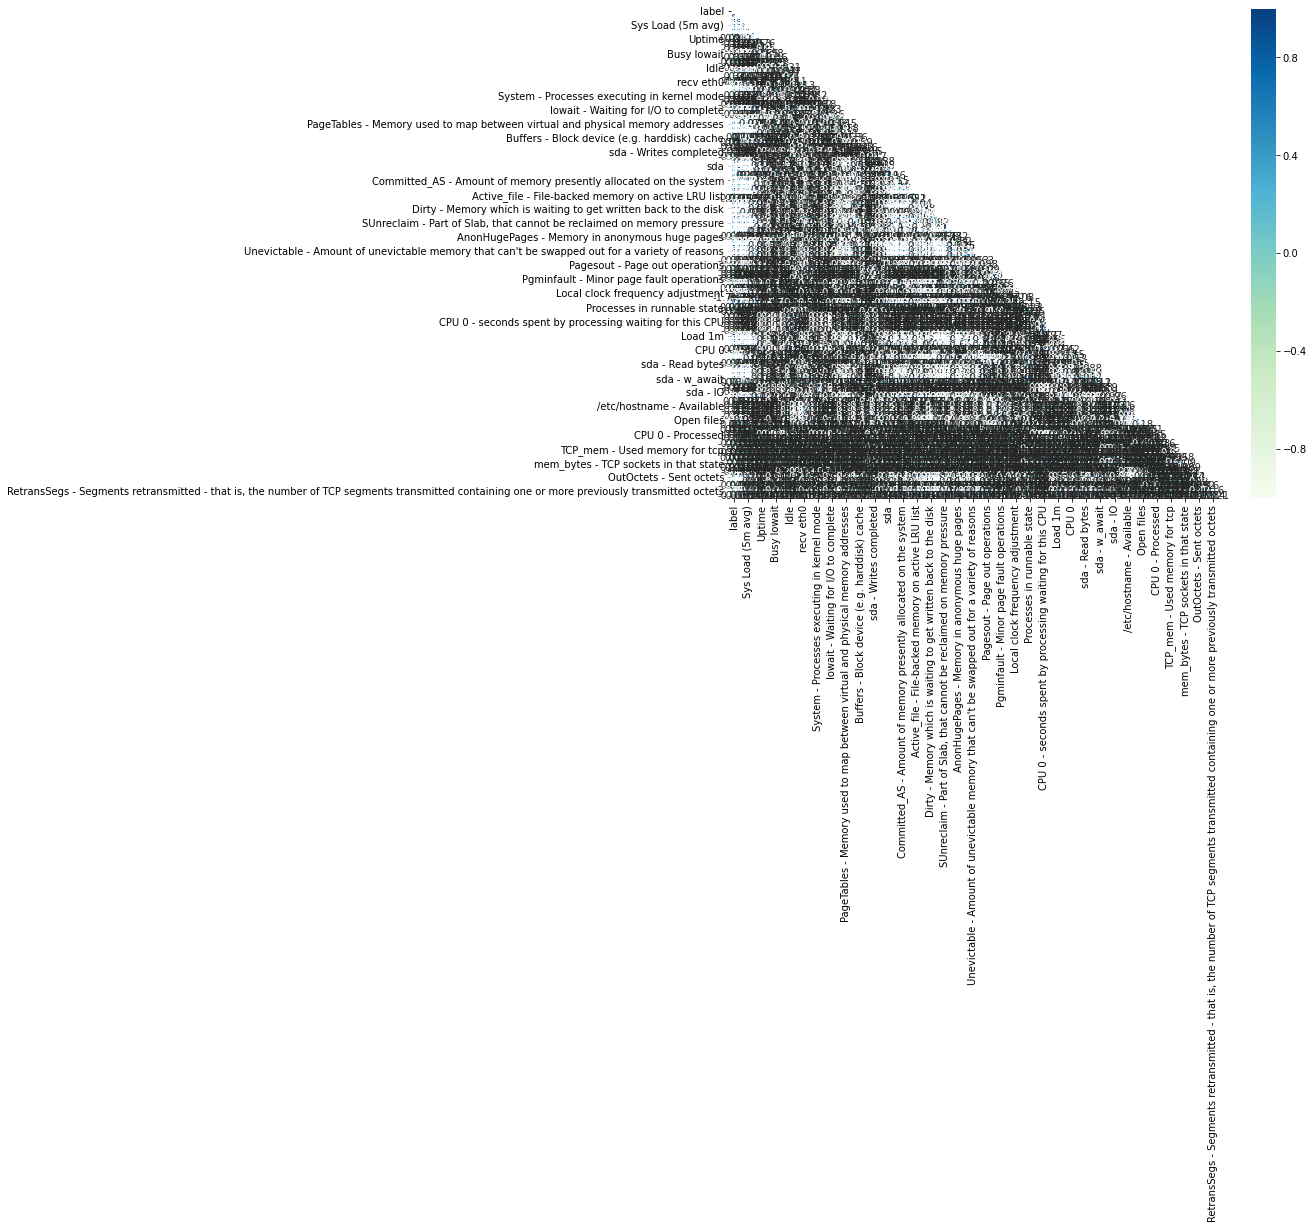

In [159]:
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=True, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [171]:
# drop unkonwn metrics looks like those are duplicates
df_index = list(txn_falure_correlation.index)

# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')

,r,p-value
txn_fail_num,0.990535,0.000000e+00
Unevictable - Amount of unevictable memory that can't be swapped out for a variety of reasons,0.983371,0.000000e+00
MLocked - Size of pages locked to memory using the mlock() system call,0.983371,0.000000e+00
"Inactive_anon - Anonymous and swap cache on inactive LRU list, including tmpfs (shmem)",0.983216,0.000000e+00
"Shmem - Used shared memory (shared between several processes, thus including RAM disks)",0.983216,0.000000e+00
...,...,...
Busy User,-0.827565,1.938071e-121
sda - Writes completed,-0.904653,1.892855e-178
sda - IO,-0.912196,1.456549e-186
sda - Write merged,-0.923126,1.016882e-199


In [178]:
selected_features = txn_falure_correlation[txn_falure_correlation.r >0.5]
selected_features = selected_features[selected_features['p-value'] < 0.05]
selected_features = selected_features.drop('txn_fail_num')
selected_features_names = selected_features.index


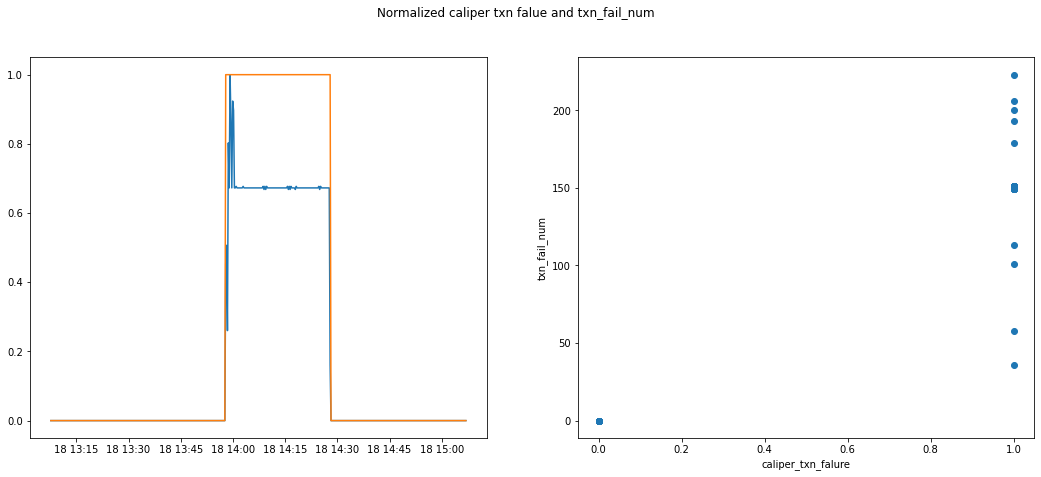

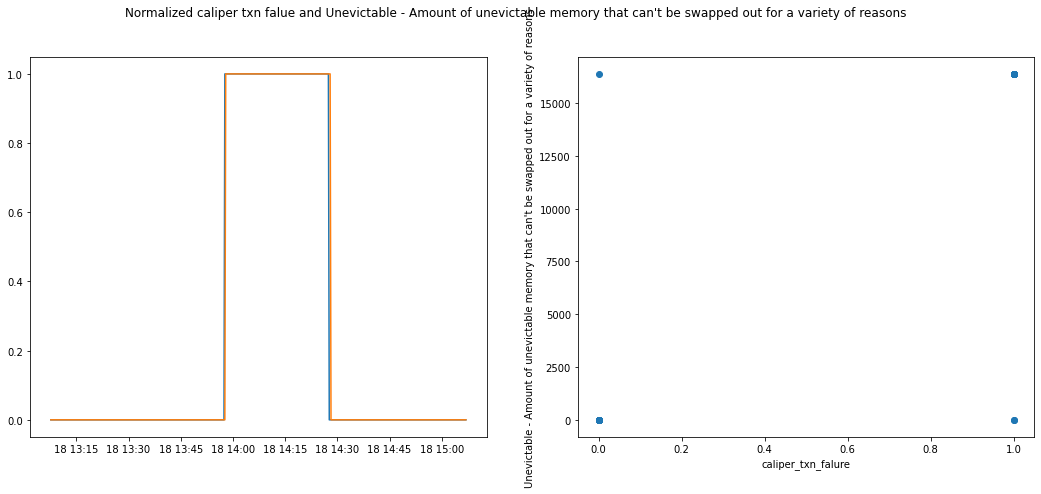

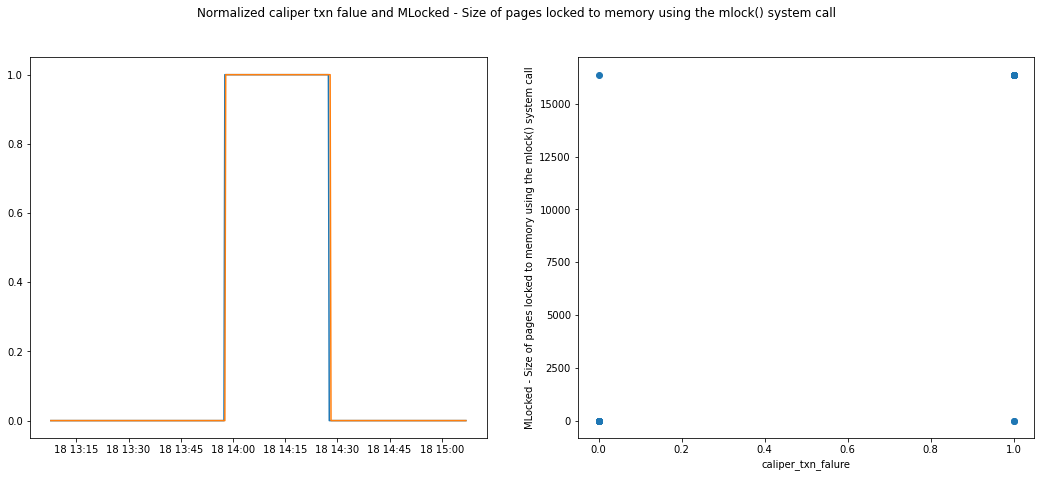

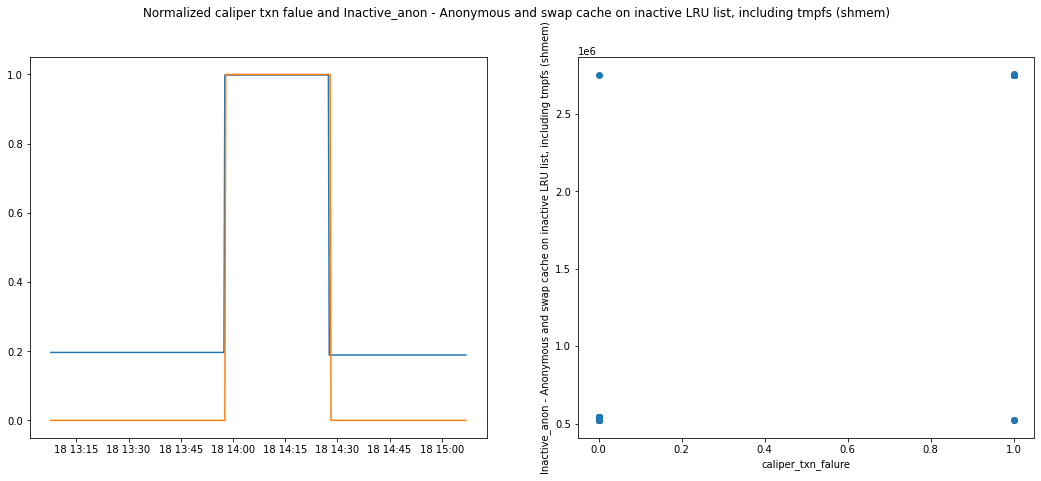

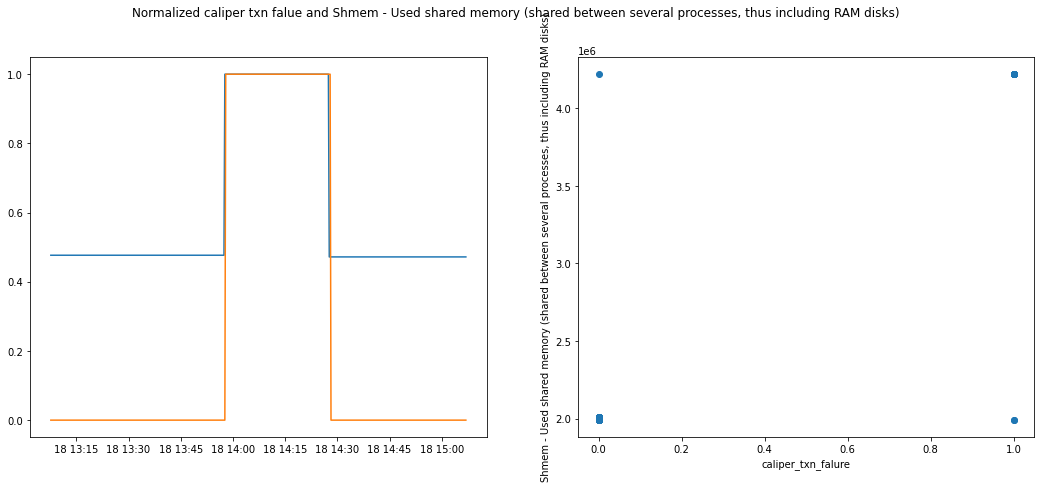

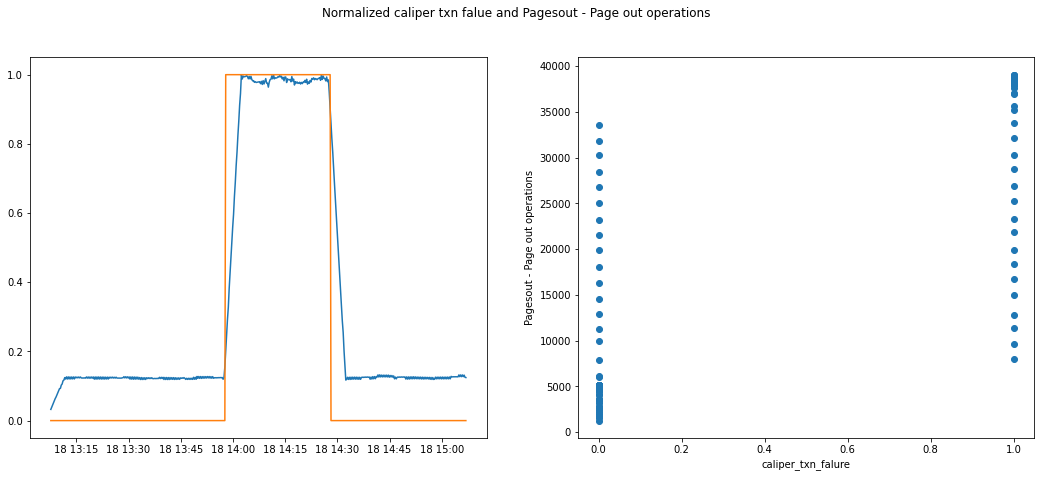

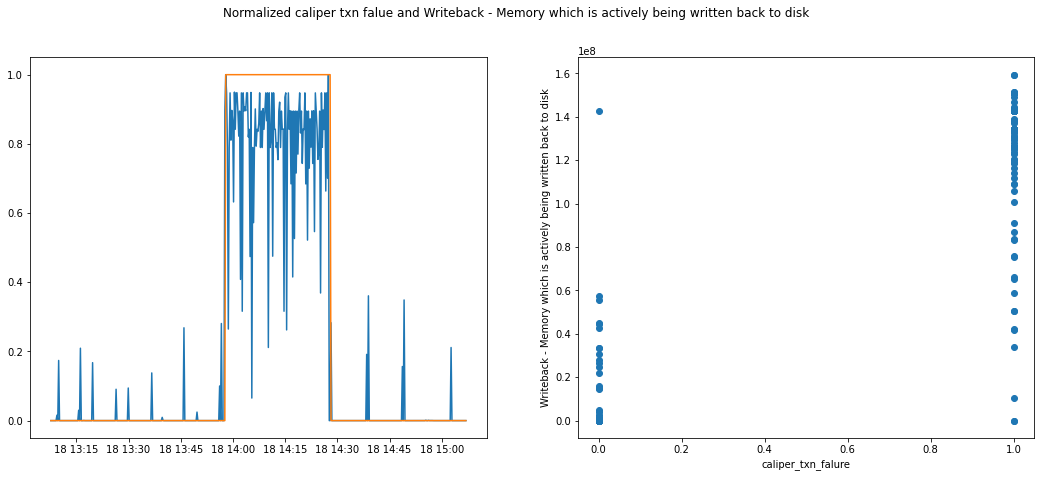

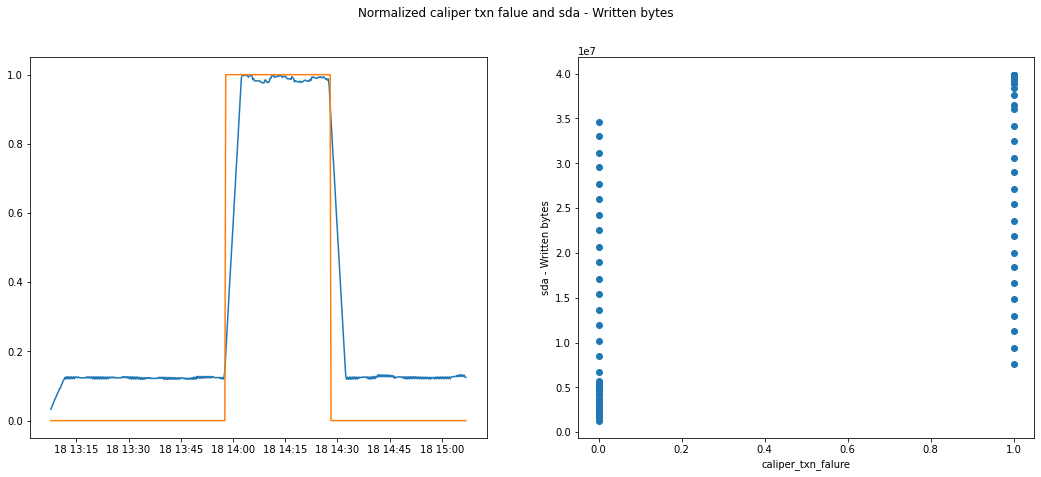

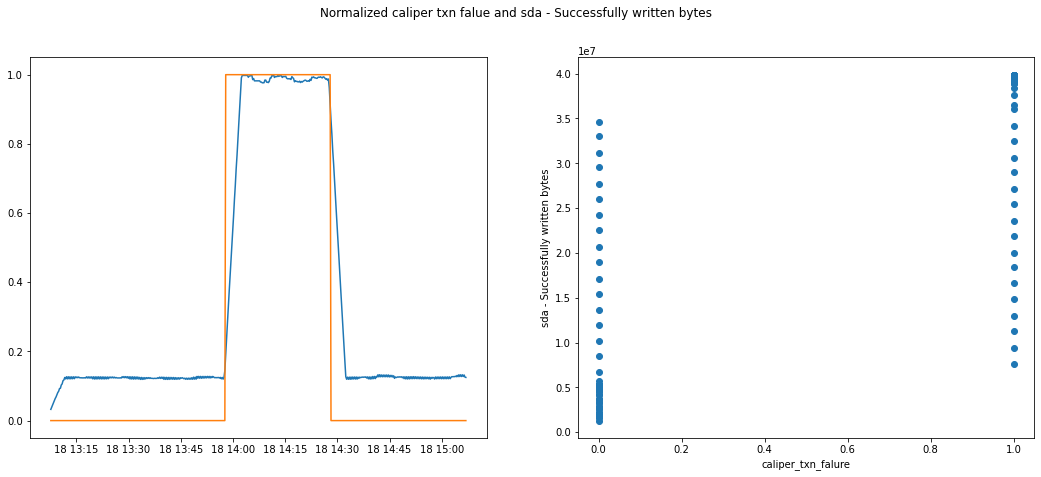

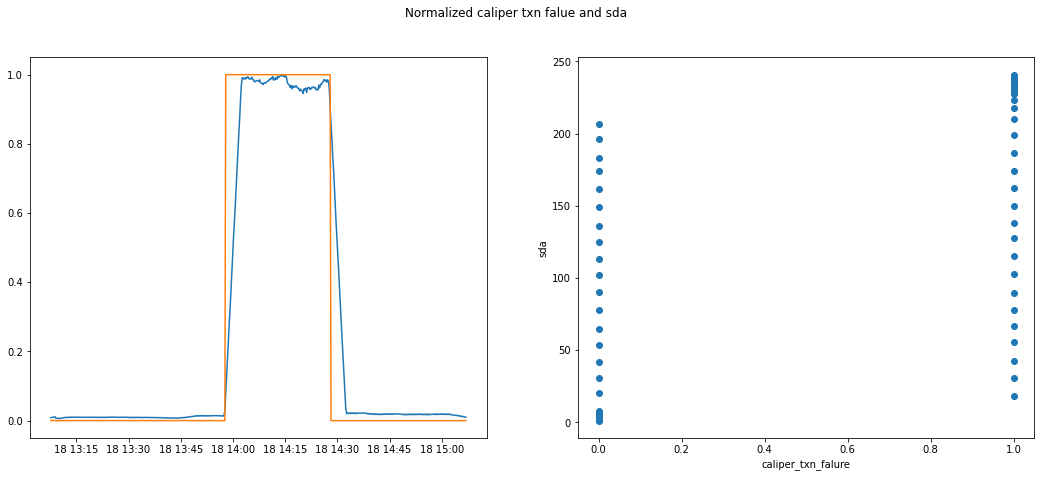

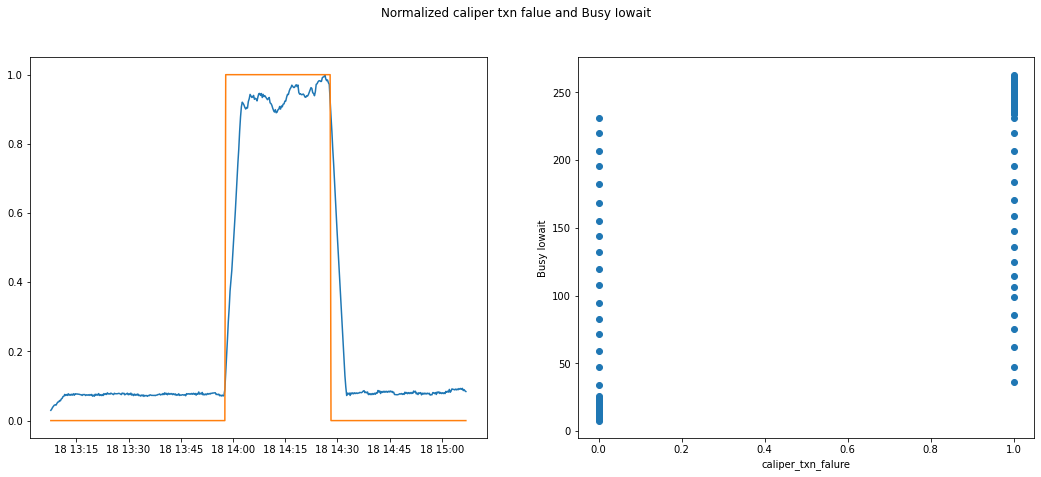

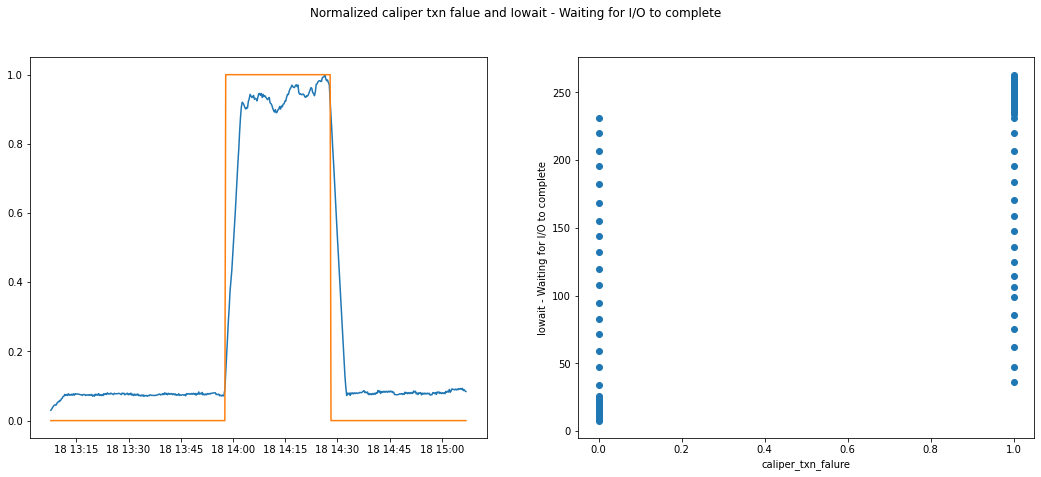

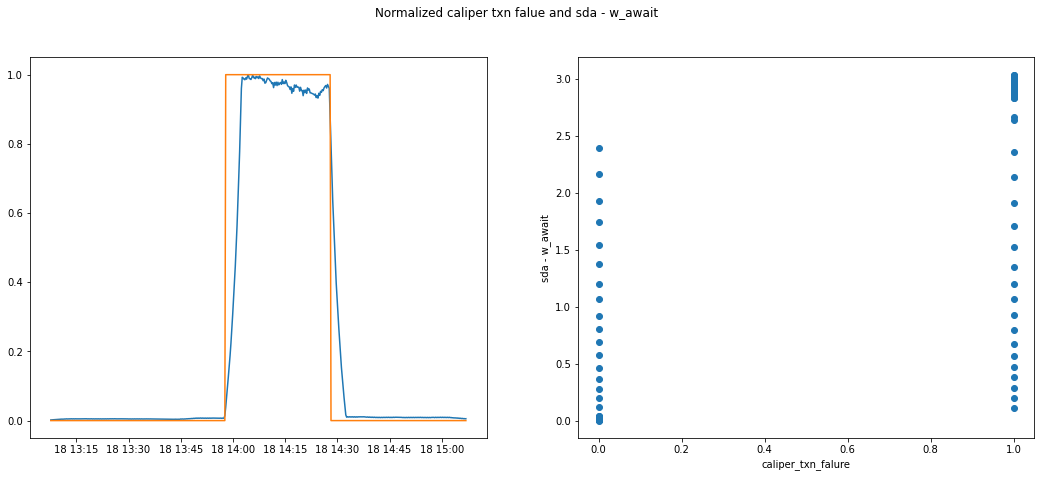

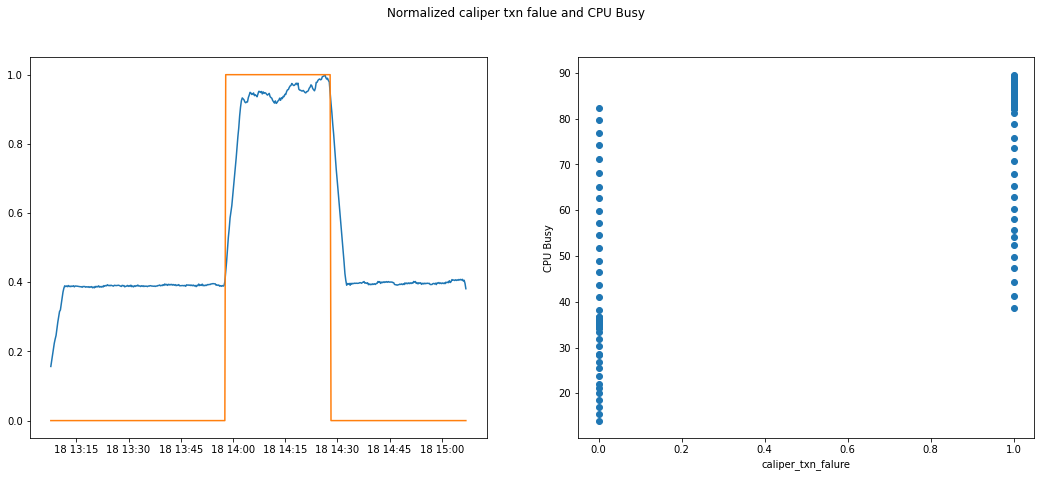

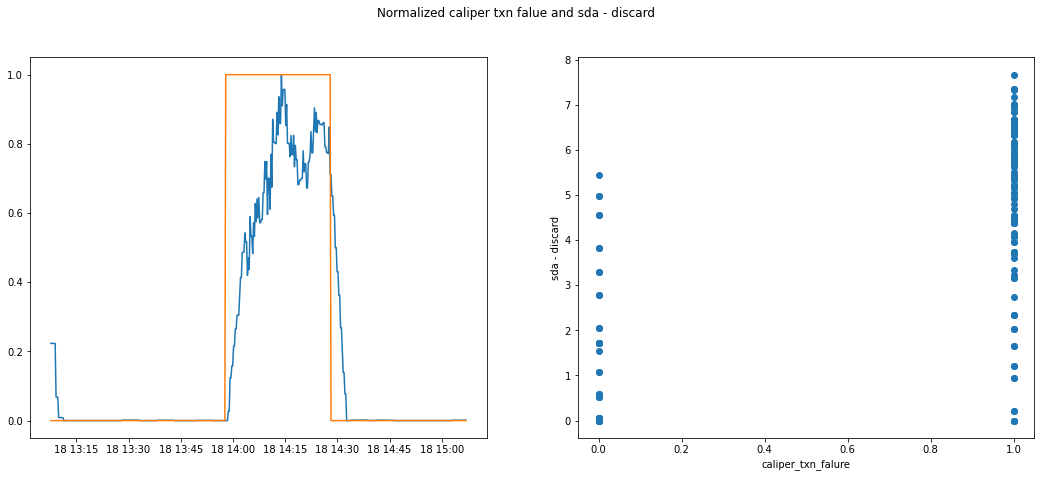

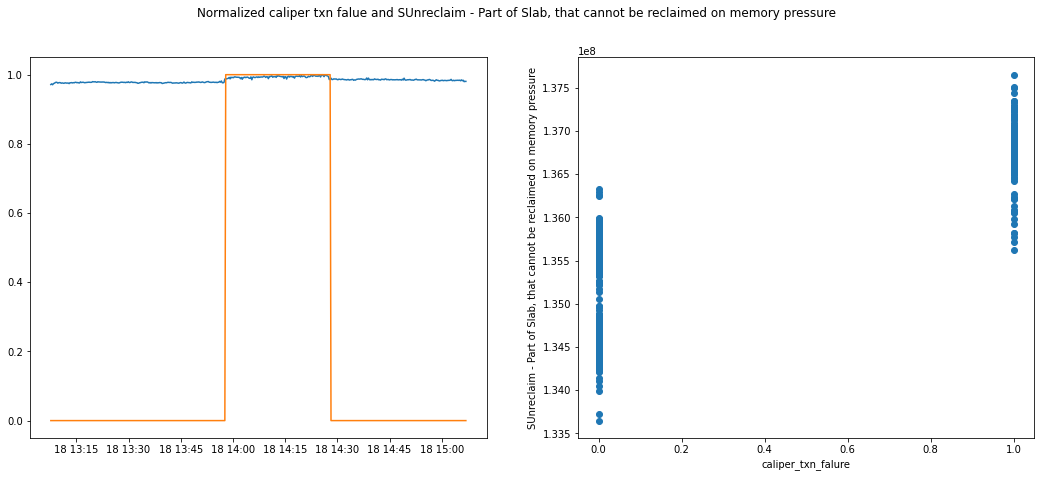

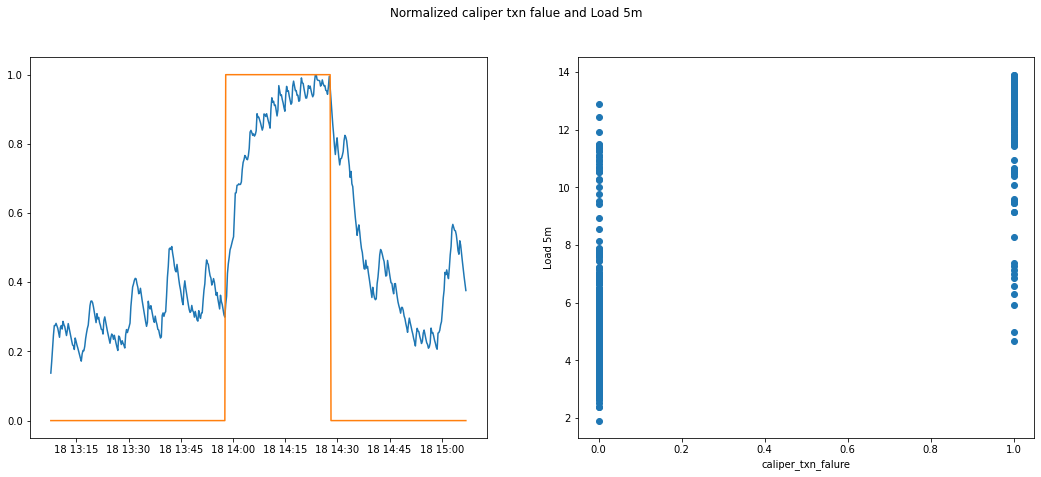

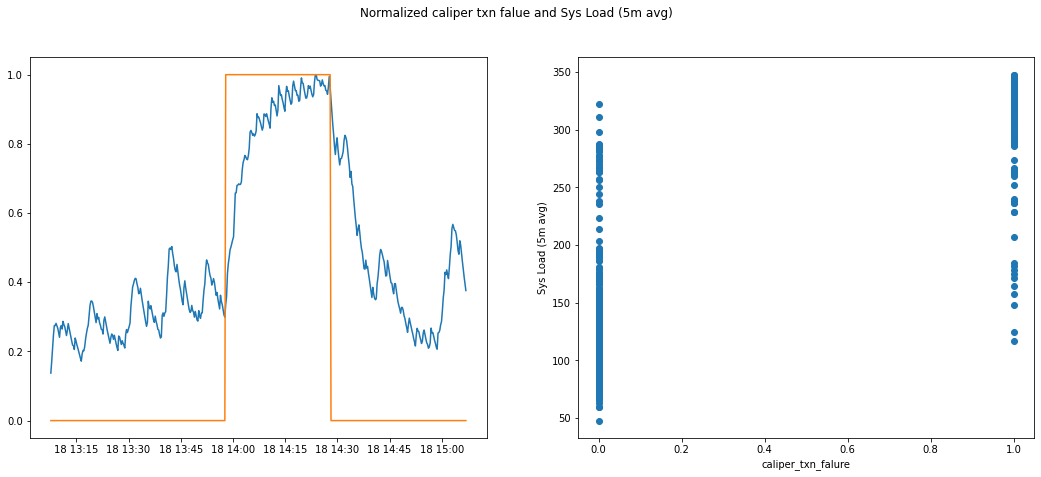

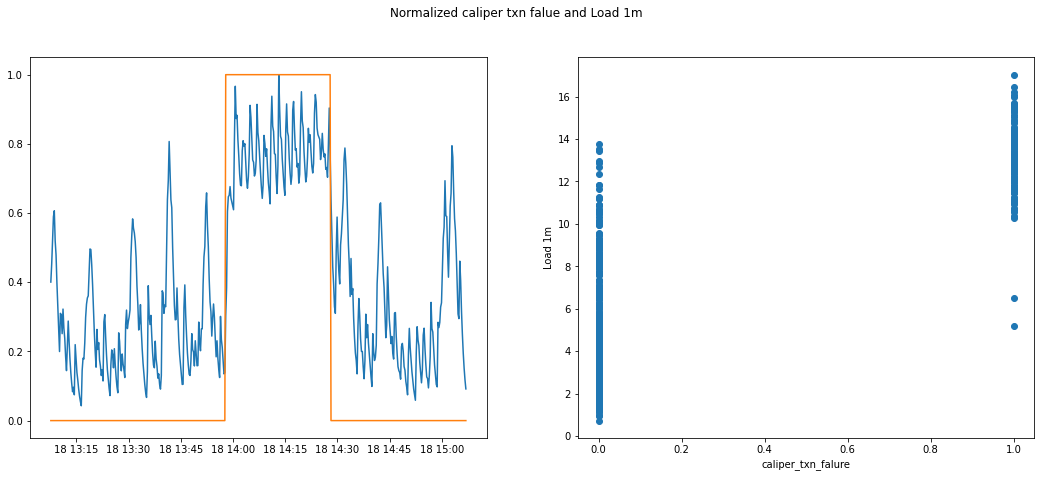

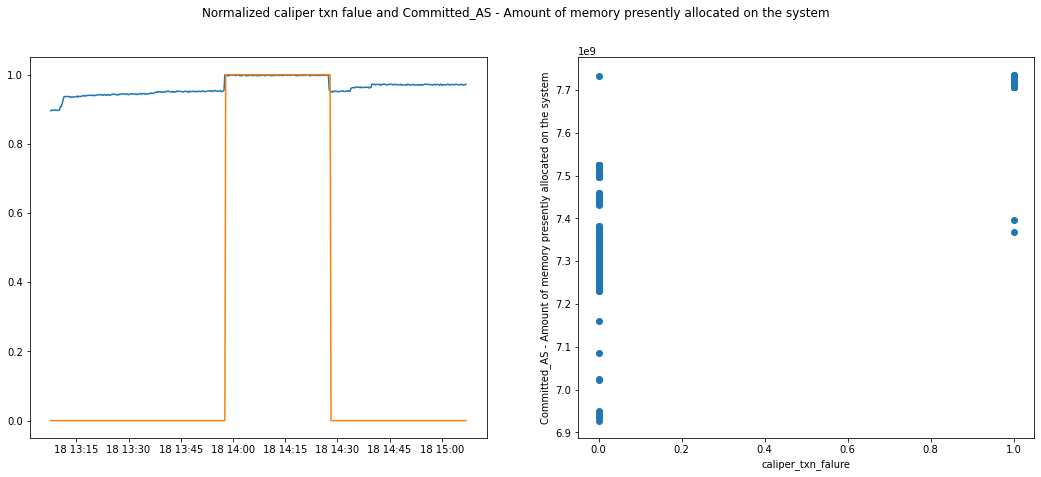

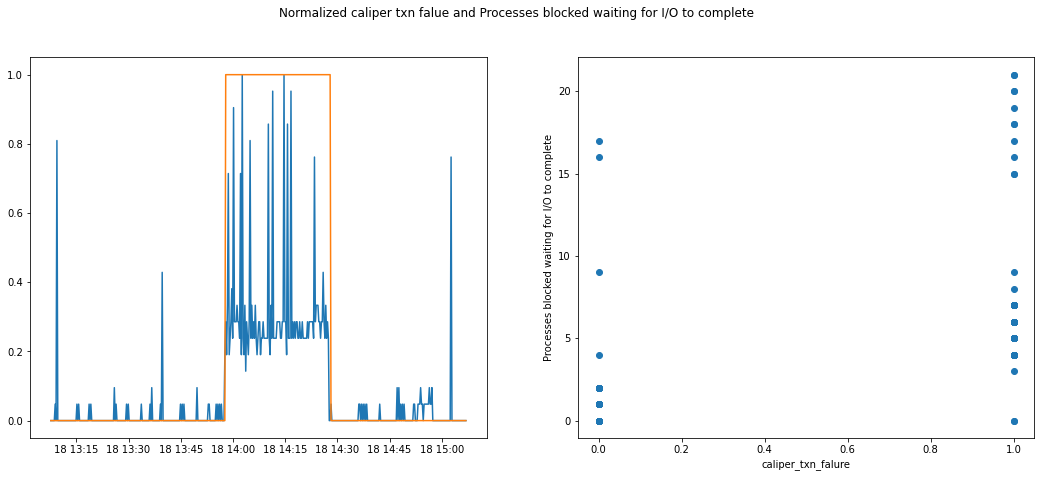

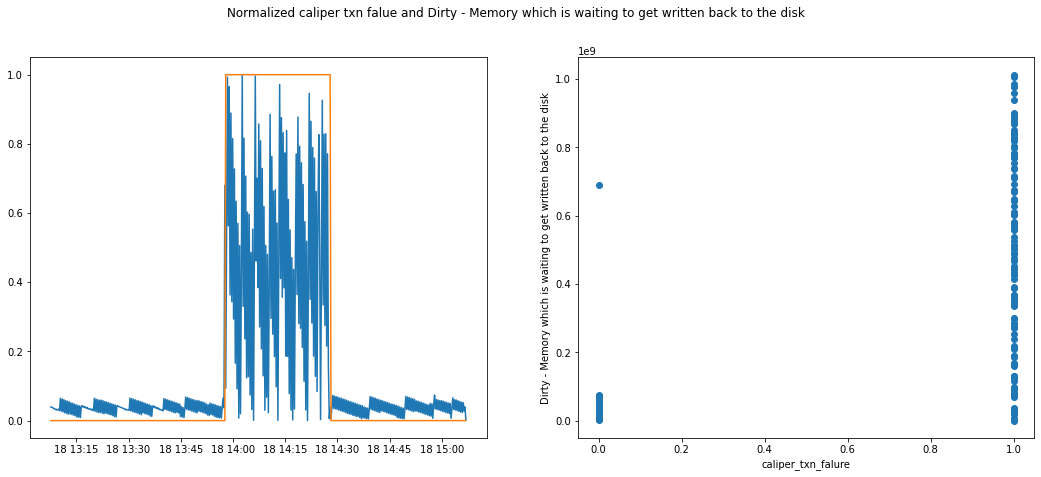

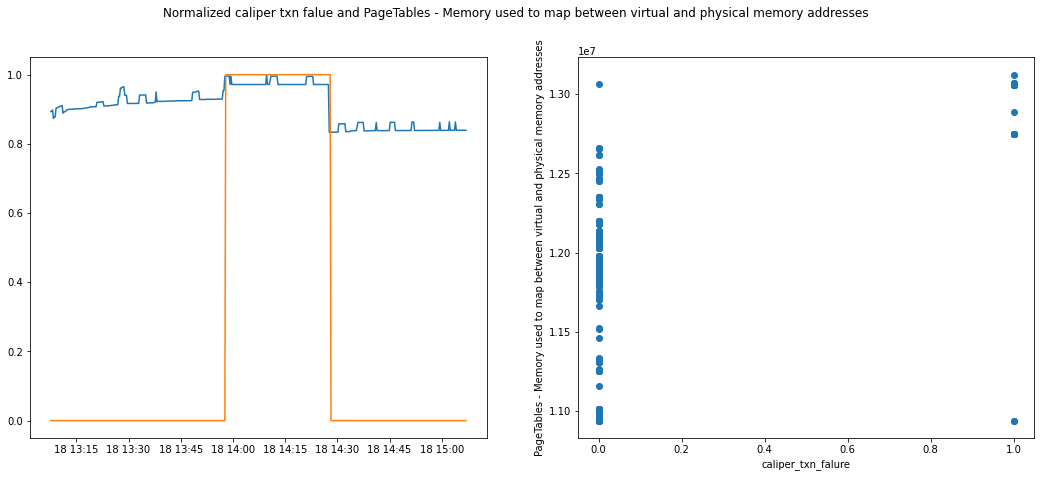

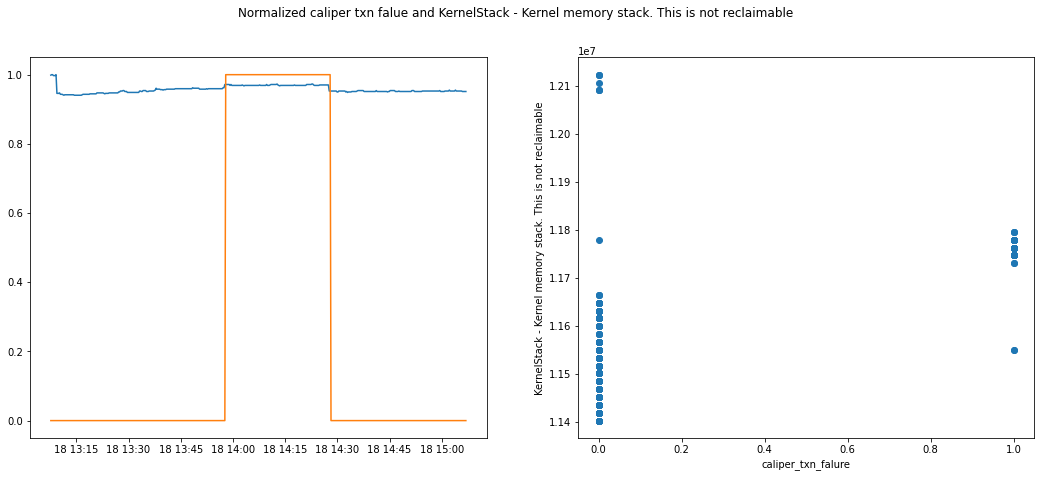

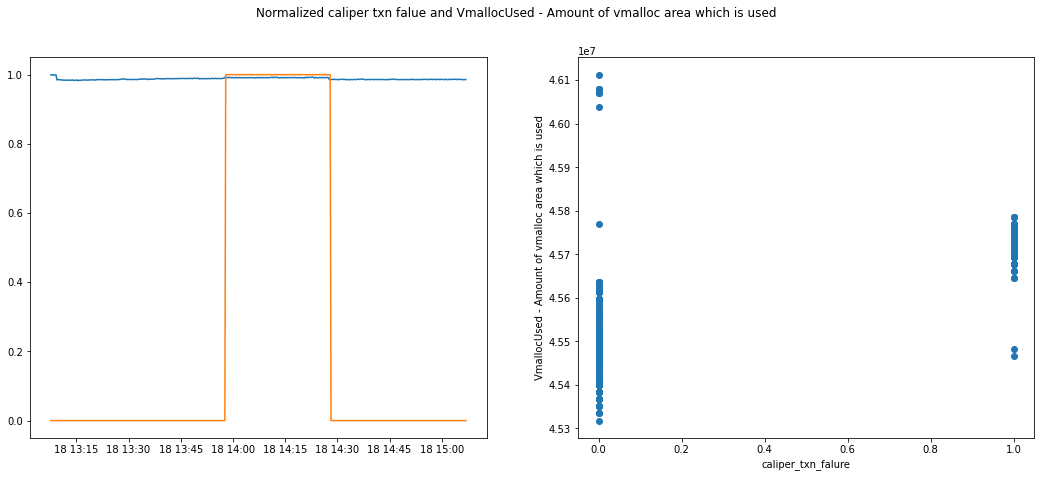

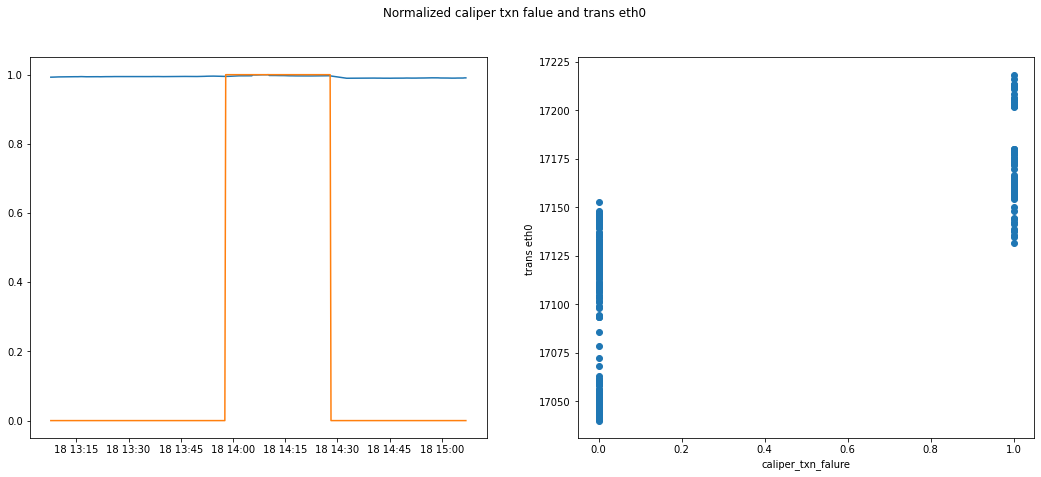

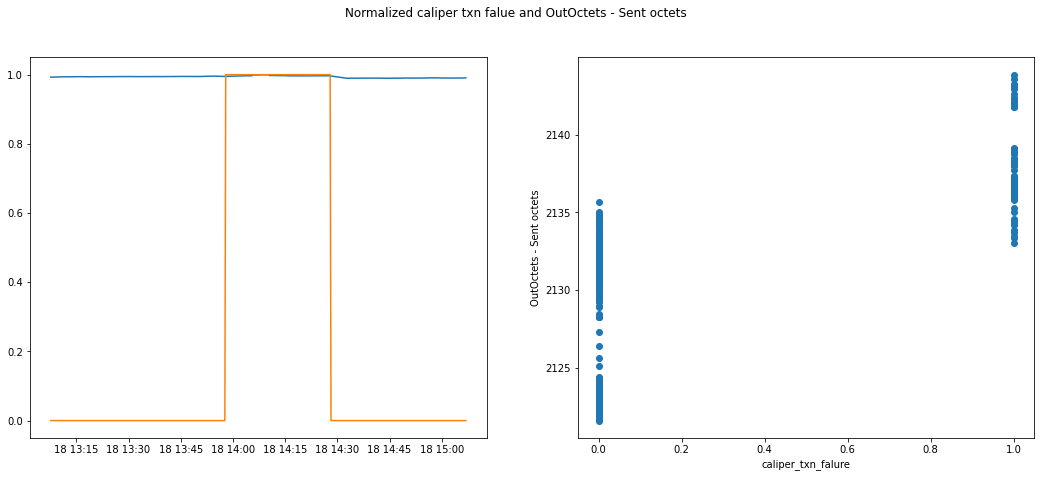

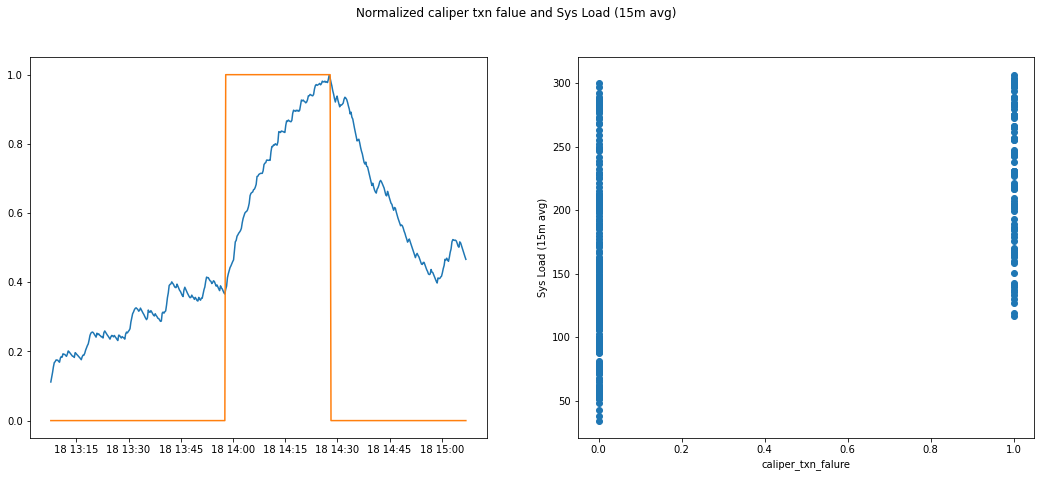

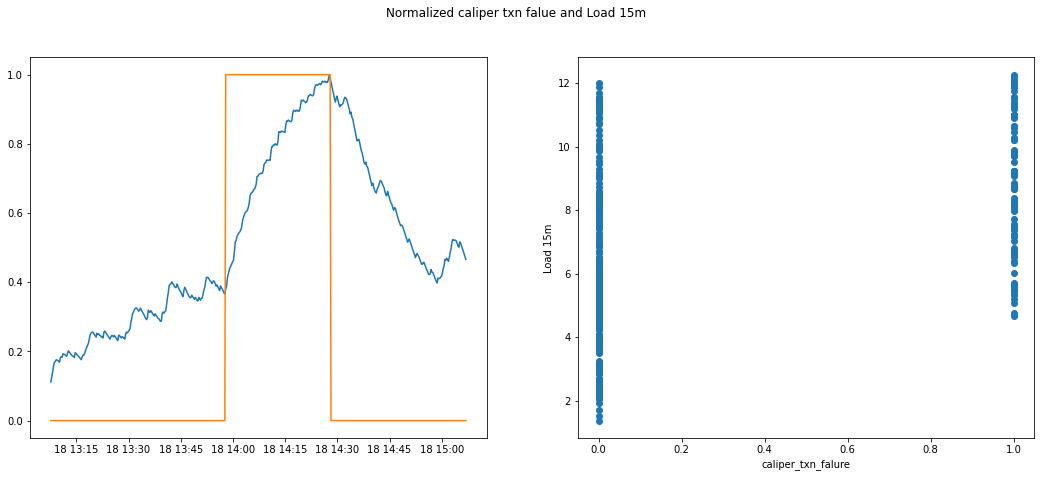

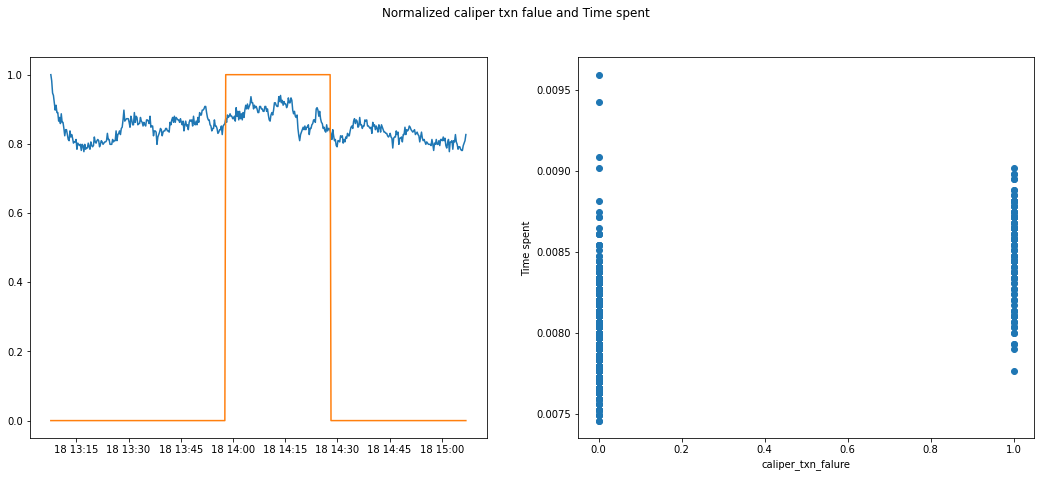

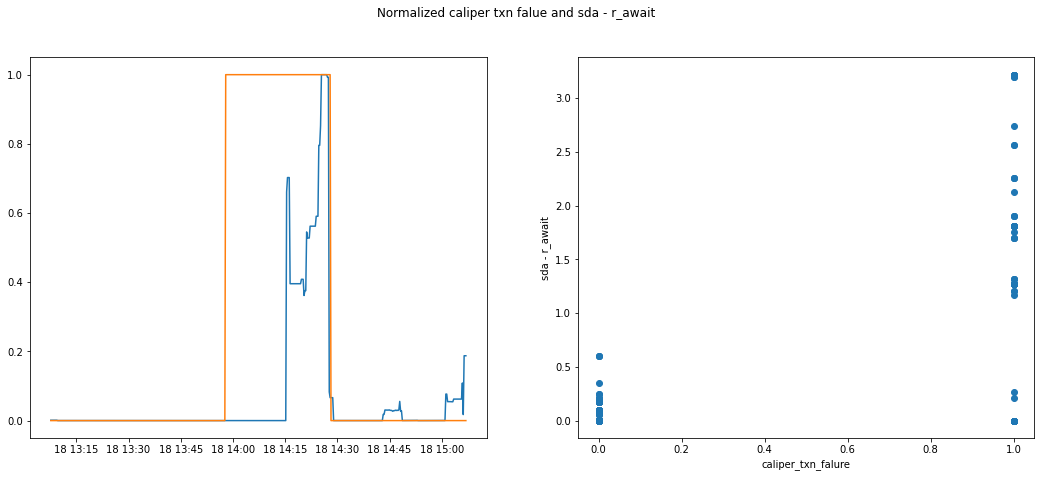

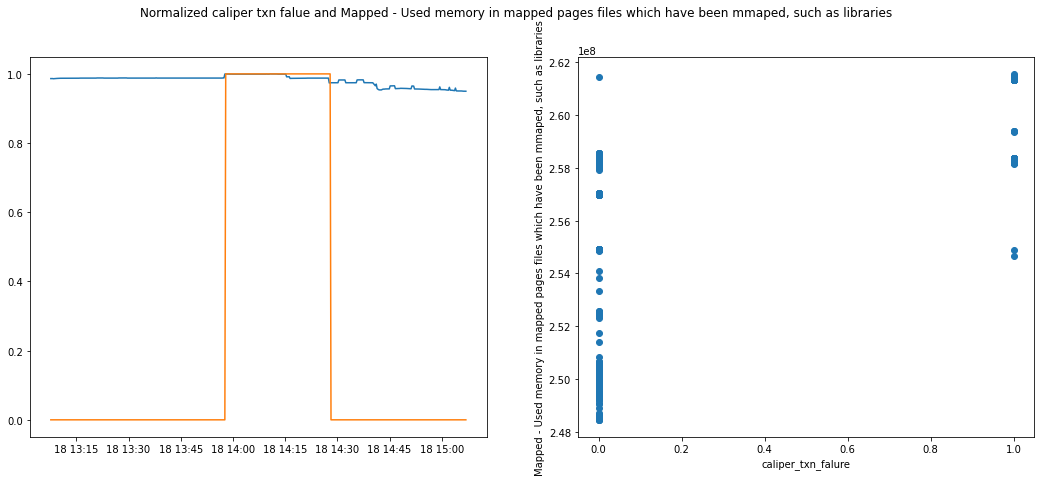

In [162]:
from sklearn.preprocessing import MinMaxScaler
normalized_label_data = label_data.copy()

for i in normalized_label_data.drop(['time'], axis=1).columns:  
    normalized_label_data[i]/=normalized_label_data[i].max()

# Old method use all selected features separately
for feature in selected_features_names:
    fig, ax =plt.subplots(figsize=(18,7))
    
    plt.subplot(1,2,1)
    plt.plot(normalized_label_data['time'], normalized_label_data[feature], label=feature)
    plt.plot(normalized_label_data['time'],normalized_label_data['label'],label='caliper_txn_falue')
    
    plt.subplot(1,2,2)
    plt.suptitle("Normalized caliper txn falue and "+feature)
    plt.scatter(label_data['label'], label_data[feature])
    plt.xlabel('caliper_txn_falure')
    plt.ylabel(feature)
    plt.show()

In [163]:
selected_features = txn_falure_correlation[txn_falure_correlation.r >0.5]
selected_features = selected_features[selected_features['p-value'] < 0.05]
selected_features_names = selected_features.index
selected_features

,r,p-value
txn_fail_num,0.990535,0.000000e+00
Unevictable - Amount of unevictable memory that can't be swapped out for a variety of reasons,0.983371,0.000000e+00
MLocked - Size of pages locked to memory using the mlock() system call,0.983371,0.000000e+00
"Inactive_anon - Anonymous and swap cache on inactive LRU list, including tmpfs (shmem)",0.983216,0.000000e+00
"Shmem - Used shared memory (shared between several processes, thus including RAM disks)",0.983216,0.000000e+00
Pagesout - Page out operations,0.944344,5.598610e-232
Writeback - Memory which is actively being written back to disk,0.943903,3.462507e-231
sda - Written bytes,0.942244,2.913994e-228
sda - Successfully written bytes,0.942244,2.913994e-228
sda,0.939745,5.153117e-224


# PCA

In [188]:
import numpy as np
from sklearn.decomposition import PCA

all_metrics = label_data.drop(['time', 'label', "txn_fail_num"], axis = 1).columns

# How to justify components?
pca = PCA(n_components=1)
pca_df = pca.fit_transform(label_data.drop(['time', 'label', 'txn_fail_num'], axis=1))
pca.fit(label_data.drop(['time', 'label'], axis=1))

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
X_pca_train, X_pca_test, Y_pca_train, Y_pca_test = train_test_split(pca_df, label_data.label, test_size=0.2, random_state=22)

[0.98596294]
[2.65104904e+11]


In [189]:
#New method combine all selected features

from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)


def dbscan_(df):
    clf.fit(df)
    pred = clf.predict(df)
    test_df=pd.DataFrame()
#     Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(df)
    # test_df['actuals']=metrics_df[list(all_metrics)]
    test_df['anomaly']=pred

    # Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)

    # test_df=classify_anomalies(test_df,metrics_df.columns[i])
    # plot_anomaly(test_df,metrics_df.columns[i])

    for i,j in enumerate(pred):
        if j == -1:
            pred[i] = 0
    return pred

def result(y_real, y_pred, method):
    accuracy = accuracy_score(y_real,y_pred)
    print(method)
    print('Accuracy: ', accuracy)
    # precision
    precision = precision_score(y_real, y_pred, average='macro')
    print('Precision: ', precision)
    # recall
    recall = metrics.recall_score(y_real, y_pred, average='macro')
    print('Recall: ', recall)
    f1_score = metrics.f1_score(y_real, y_pred, average='macro') 
    print('F1 score: ', f1_score)
    
    # AUC curve
    fpr, tpr, threshold = metrics.roc_curve(y_real, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

All metrics
Accuracy:  0.24476987447698745
Precision:  0.3399014778325123
Recall:  0.4097159524967011
F1 score:  0.23141883615794046


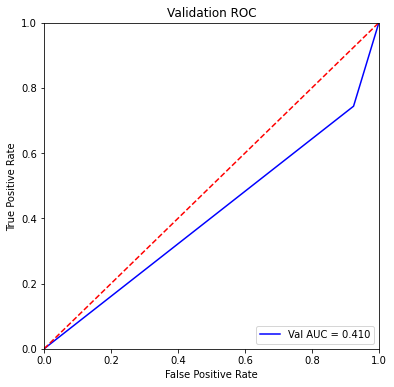

--- 0.6300489902496338 seconds ---
Correlation selected metrics
Accuracy:  0.23640167364016737
Precision:  0.3202791461412151
Recall:  0.39865036923860453
F1 score:  0.22290270137852705


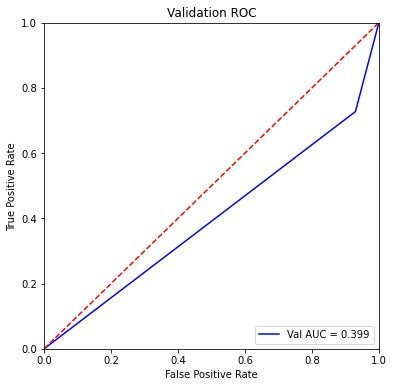

--- 0.4828155040740967 seconds ---
PCA selected metrics
Accuracy:  0.36610878661087864
Precision:  0.6244252873563219
Recall:  0.5701669097391022
F1 score:  0.35490279045943485


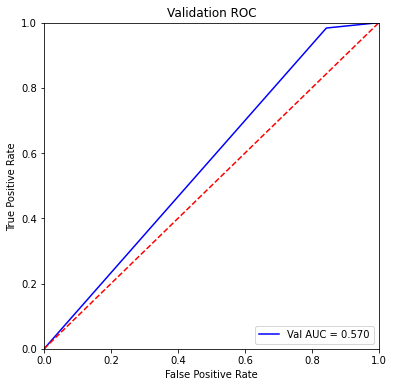

--- 0.4500081539154053 seconds ---


In [190]:
start_time = time.time()
all_metrics_pred = dbscan_(label_data[list(all_metrics)])       
result(label_data.label, all_metrics_pred, "All metrics")        
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
selected_features_pred = dbscan_(label_data[list(selected_features.index)]) 
result(label_data.label, selected_features_pred, "Correlation selected metrics")   
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
selected_features_pred = dbscan_(pca_df)       
result(label_data.label, selected_features_pred, "PCA selected metrics")   
print("--- %s seconds ---" % (time.time() - start_time))

# KNN

In [167]:
from sklearn.cluster import KMeans

    
def cluster(data):
    data = pd.DataFrame(data)
    clf = KMeans(n_clusters=2)
    clf.fit(data)
    
    # always classify anomaly as 1
    labels = clf.labels_
    one_counts = list(labels).count(1)
    zero_counts = list(labels).count(0)
    
#     if one_counts > zero_counts:
# #         print(labels)
#         labels = [not i for i in labels]
#         labels = map(int, labels)
#         print(labels)
    
    return labels

def plot_kmeans(df, predictions, column, plot=True):
    
#     predictions = pd.DataFrame(predictions, columns = ['predictions'])
    df_copy = df.copy()
    df_copy['predictions'] = predictions
    
    if not plot:
        return df_copy

    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df_copy['predictions'] == 1, ['time', column]] #anomaly
    b = df.loc[df_copy['label'] == 1, ['time',column]] #anomaly
    ax.plot(df_copy['time'], df_copy[column], color='blue')

    ax.scatter(b['time'],b[column], color='green', label='Measured anomaly')
    ax.scatter(a['time'],a[column], color='red', label='Predicted Anomaly')
    plt.xlabel('Date Time Integer')
    plt.ylabel(column)

    plt.legend()
    plt.show()
    return df_copy
    
def evaluate(df):
    # Evaluation
    
    # accuracy
    true_label = df['label']
    pred_label = df['predictions']
    accuracy = accuracy_score(true_label,pred_label)
    print('Accuracy: ', accuracy)
    # precision
    precision = precision_score(true_label, pred_label, average='macro')
    print('Precision: ', precision)
    # recall
    recall = metrics.recall_score(true_label, pred_label, average='macro')
    print('Recall: ', recall)
    f1_score = metrics.f1_score(true_label, pred_label, average='macro') 
    print('F1 score: ', f1_score)

    # AUC curve
    fpr, tpr, threshold = metrics.roc_curve(true_label, pred_label)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

kmeans on all metrics
Accuracy:  0.608786610878661
Precision:  0.6964285714285714
Recall:  0.7380952380952381
F1 score:  0.6046319272125724


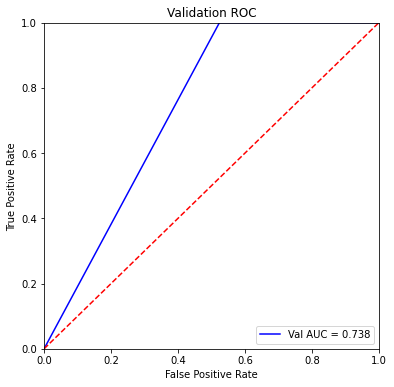

--- 0.25345635414123535 seconds ---
kmeans on correlation metrics
Accuracy:  0.9225941422594143
Precision:  0.9482676791646891
Recall:  0.849839109197398
F1 score:  0.8859284198577169


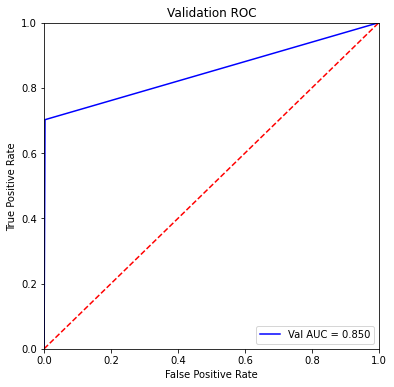

--- 0.29792284965515137 seconds ---
kmeans op PCA
Accuracy:  0.3912133891213389
Precision:  0.30357142857142855
Recall:  0.2619047619047619
F1 score:  0.28120300751879695


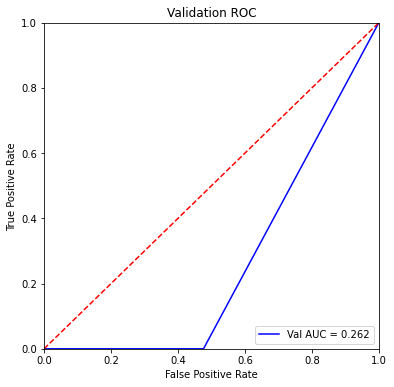

--- 0.13618016242980957 seconds ---


In [191]:
start_time=time.time()
clf = KMeans(n_clusters=2)
clf.fit(label_data.drop(["label", "time"], axis=1))
result(label_data.label, clf.labels_, "kmeans on all metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time=time.time()
clf = KMeans(n_clusters=2)
clf.fit(label_data[list(selected_features_names)])
result(label_data.label, clf.labels_, "kmeans on correlation metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time=time.time()
clf = KMeans(n_clusters=2)
clf.fit(pca_df)
result(label_data.label, clf.labels_, "kmeans op PCA")
print("--- %s seconds ---" % (time.time() - start_time))

# SUPERVISED METHODS
## KNN

Knn on all metrics
Accuracy:  0.9895833333333334
Precision:  0.9935064935064934
Recall:  0.975
F1 score:  0.9839115133232781


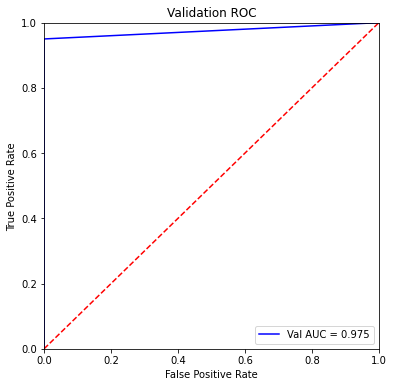

--- 0.20391225814819336 seconds ---
Knn on correlation metrics
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


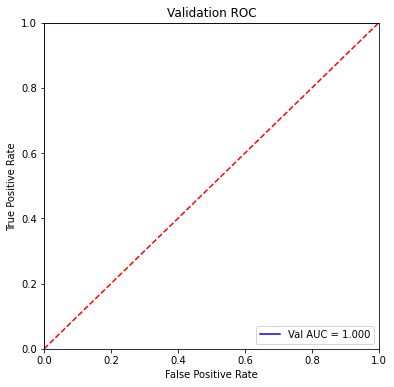

--- 0.1944286823272705 seconds ---
Knn on pcs data
Accuracy:  0.8541666666666666
Precision:  0.7777777777777778
Recall:  0.8157894736842105
F1 score:  0.7936117936117936


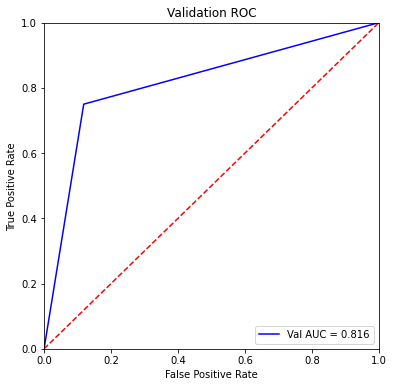

--- 0.13069772720336914 seconds ---


In [192]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

start_time = time.time()
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
result(Y_test, predictions, "Knn on all metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train[list(selected_features_names)], Y_train)
predictions = model.predict(X_test[list(selected_features_names)])
result(Y_test, predictions, "Knn on correlation metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_pca_train, Y_pca_train)
predictions = model.predict(X_pca_test)
result(Y_pca_test, predictions, "Knn on pcs data")
print("--- %s seconds ---" % (time.time() - start_time))

# SVM

SVM on all metrics
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


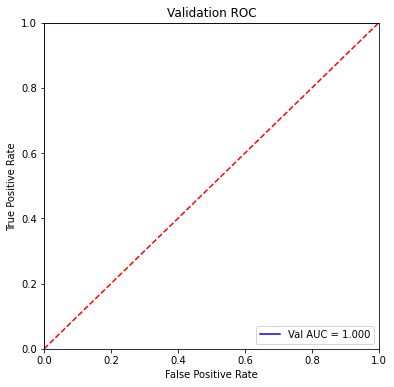

--- 0.1389024257659912 seconds ---
SVM on correlation metrics
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


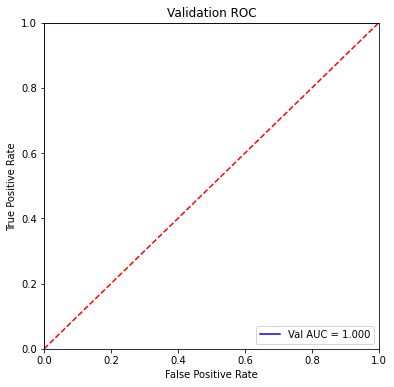

--- 0.12697243690490723 seconds ---
SVM on PCA metrics
Accuracy:  0.8958333333333334
Precision:  0.8333333333333333
Recall:  0.9342105263157895
F1 score:  0.8647887323943662


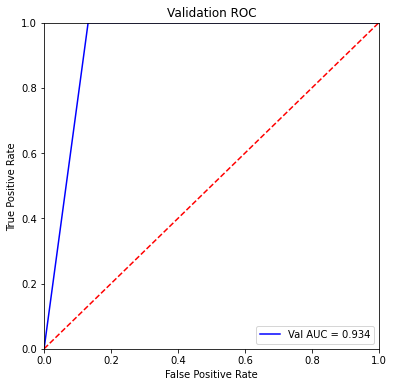

--- 0.1264209747314453 seconds ---


In [197]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
result(Y_test, pred, "SVM on all metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train[selected_features_names], Y_train)
pred = clf.predict(X_test[selected_features_names])
result(Y_test, pred, "SVM on correlation metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_pca_train, Y_pca_train)
pred = clf.predict(X_pca_test)
result(Y_pca_test, pred, "SVM on PCA metrics")
print("--- %s seconds ---" % (time.time() - start_time))



SVM on all metrics
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


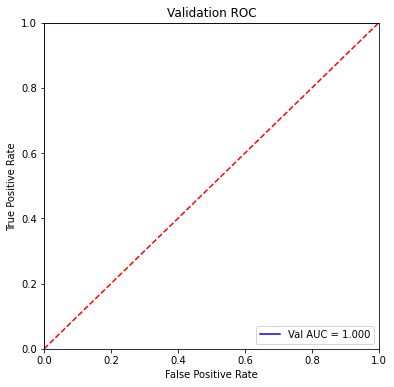

--- 0.13399457931518555 seconds ---
SVM on correlation metrics
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 score:  1.0


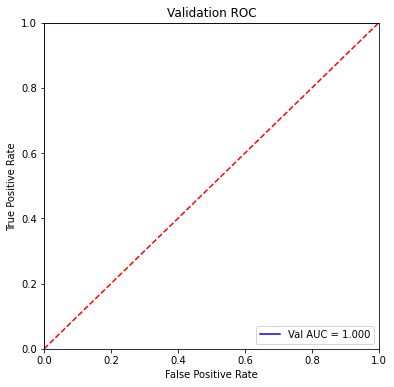

--- 0.1320657730102539 seconds ---
SVM on PCA metrics
Accuracy:  0.8958333333333334
Precision:  0.8333333333333333
Recall:  0.9342105263157895
F1 score:  0.8647887323943662


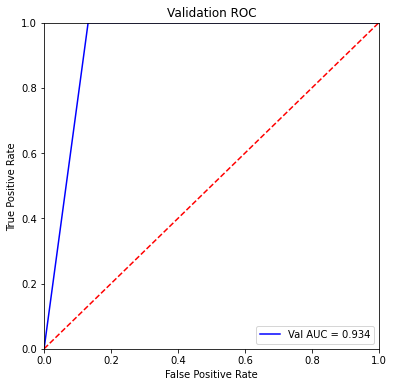

--- 0.1261134147644043 seconds ---


In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)

start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
result(Y_test, pred, "SVM on all metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train[selected_features_names], Y_train)
pred = clf.predict(X_test[selected_features_names])
result(Y_test, pred, "SVM on correlation metrics")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_pca_train, Y_pca_train)
pred = clf.predict(X_pca_test)
result(Y_pca_test, pred, "SVM on PCA metrics")
print("--- %s seconds ---" % (time.time() - start_time))


1622749052.7216642
1622749052.7224586
